# Train an Oracle for Othello at ply 44

The result from Edax eval shows an accuracy of 71% at ply 44 (16 empty squares). To significantly surpass Edax we target a model with >80% accuracy.

In [ ]:
cd /content/drive/MyDrive/EdaxAnalyzer_Data

/content/drive/MyDrive/EdaxAnalyzer_Data


## Data Preperation

Generate data & label:

```
X, X_train, X_test # data, formatted as a len-64 ternary string of 0,1,-1. 0 -> empty_square, 1 -> X_square, -1 -> O_square

y, y_train, y_test # label, transformed from score (difference in square) to 3 positivities
```



In [ ]:
def extract_states(test_obf_file):
    states = []
    mapping = {'X': 1, '-': 0, 'O': -1}
    with open(test_obf_file, 'r') as file:
        for line in file:
            obf = line.split()[0]
            new_state = np.array([mapping[char] for char in obf])
            # print(new_state)
            states.append(new_state)
    return np.array(states)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def extract_scores(solution_file):
    scores = []
    with open(solution_file, 'r') as file:
        # Skip the header and the line below it
        next(file)
        next(file)

        for line in file:
            if not line.strip():
                continue  # Skip any empty lines
            parts = line.split('|')[1].split()
            depth = int(parts[0].strip())
            score = parts[1].strip()

            # Check if the depth is 16, then extract the score
            # assert(depth == 16)
            scores.append(int(score))

    return np.array(scores)

In [ ]:
def transform_to_positivity(arr):
    positivity_array = np.zeros_like(arr, dtype=np.int16)
    positivity_array[arr > 0] = 1
    positivity_array[arr < 0] = -1
    return positivity_array

In [ ]:
# load data
scores_16_16 = extract_scores("100k_20240502/eval_16_16_100k_20240502.txt")
scores_0_16 = extract_scores("100k_20240502/eval_0_16_100k_20240502.txt")
X = extract_states("100k_20240502/test_obf_16_100k_20240502")

transformed_scores_16 = transform_to_positivity(scores_16_16)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, transformed_scores_16, test_size=0.2)

# transform y to catagorical
y_train += 1
y_test += 1
y_test

array([0, 0, 2, ..., 2, 0, 0], dtype=int16)

## FC model

### Modeling

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf

# Define your fully connected neural network model architecture
def create_fc_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Load your dataset and preprocess it
# X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Define your model hyperparameters
input_shape = (64,)  # Input shape of your data (for flattened input)
num_classes = 3  # Number of classes in your dataset
learning_rate = 0.001
batch_size = 32
epochs = 100

# Create an instance of your model
model = create_fc_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [ ]:
# Report loss & Acc for epoch 0 as it's not reported by model.fit
initial_training_loss, initial_training_accuracy = model.evaluate(X_train, y_train)
initial_testing_loss, initial_testing_accuracy = model.evaluate(X_test, y_test)

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # Only consider improvements that decrease the loss by at least 0.001
    patience=20,      # Number of epochs with no significant improvement
    verbose=1,
    mode='min'
)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

625/625 [==============================] - 2s 3ms/step - loss: 1.2818 - accuracy: 0.2379
Epoch 1/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.7489 - accuracy: 0.6524 - val_loss: 0.7273 - val_accuracy: 0.6666
Epoch 2/100
2500/2500 [==============================] - 9s 4ms/step - loss: 0.7291 - accuracy: 0.6675 - val_loss: 0.7259 - val_accuracy: 0.6669
Epoch 3/100
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7243 - accuracy: 0.6686 - val_loss: 0.7226 - val_accuracy: 0.6690
Epoch 4/100
2500/2500 [==============================] - 9s 4ms/step - loss: 0.7204 - accuracy: 0.6713 - val_loss: 0.7245 - val_accuracy: 0.6683
Epoch 5/100
2500/2500 [==============================] - 6s 3ms/step - loss: 0.7174 - accuracy: 0.6731 - val_loss: 0.7255 - val_accuracy: 0.6686
Epoch 6/100
2500/2500 [==============================] - 9s 3ms/step - loss: 0.7137 - accuracy: 0.6744 - val_loss: 0.7287 - val_accuracy: 0.6672
Epoch 7/100
2500/2500 [==================

In [ ]:
# Optionally, save the trained model
model.save('models/FC_128_64_epoch100.keras')

### Result

Training Curves

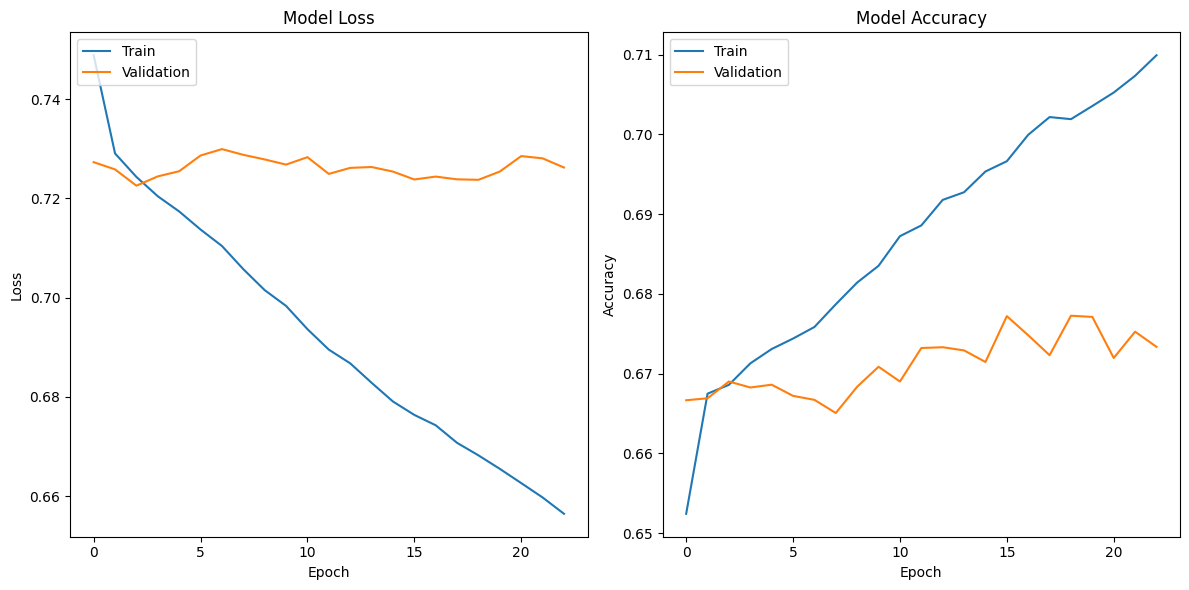

In [ ]:
def plot_training_history(history):
  # Plot training & validation loss values
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  if 'val_loss' in history.history:
      plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation accuracy values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])
  if 'val_accuracy' in history.history:
      plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

plot_training_history(history)

Classification Report

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generating and printing the classification report
report = classification_report(y_test, y_pred_classes)
print(report)

625/625 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      8574
           1       0.33      0.00      0.00       842
           2       0.68      0.77      0.73     10584

    accuracy                           0.67     20000
   macro avg       0.56      0.46      0.46     20000
weighted avg       0.66      0.67      0.66     20000



### Model Improvement

Methods tried:
*   Increasing model size: overfitting
*   Early stop by training loss: overfitting
*   List item
*   List item




#### Draws are rare (~3%) and trained classification model will predict extremely low probability for draws, resulting in 0/20000 predicted in a test sample:

In [ ]:
# load data
scores_16_16 = extract_scores("100k_20240502/eval_16_16_100k_20240502.txt")
scores_0_16 = extract_scores("100k_20240502/eval_0_16_100k_20240502.txt")
X = extract_states("100k_20240502/test_obf_16_100k_20240502")

transformed_scores_16 = transform_to_positivity(scores_16_16)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, transformed_scores_16, test_size=0.2)

In [ ]:
# Using numpy.unique to find unique elements and their counts
unique_elements, counts = np.unique(y_test, return_counts=True)

# Printing the elements and their frequencies
for element, count in zip(unique_elements, counts):
    print(f'Element {element}: {count} times')

Element -1: 8682 times
Element 0: 877 times
Element 1: 10441 times


625/625 [==============================] - 1s 2ms/step


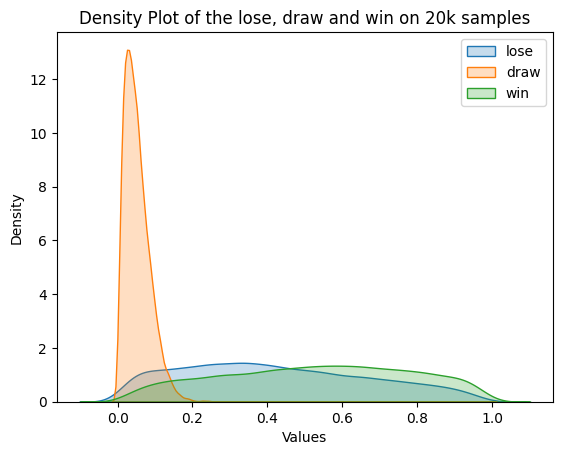

In [ ]:
import seaborn as sns

# Predicting test data

y_pred = model.predict(X_test)

# Extract columns
first_column = y_pred[:, 0]
second_column = y_pred[:, 1]
third_column = y_pred[:, 2]

# Create the density plot for each column
sns.kdeplot(first_column, fill=True, label='lose')
sns.kdeplot(second_column, fill=True, label='draw')
sns.kdeplot(third_column, fill=True, label='win')

# Adding titles and labels
plt.title('Density Plot of the lose, draw and win on 20k samples')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()  # Add a legend to identify each plot

plt.show()

In [ ]:
def transform_to_nonnegativity(arr):
    positivity_array = np.zeros_like(arr, dtype=np.int16)
    positivity_array[arr >= 0] = 1
    positivity_array[arr < 0] = 0
    return positivity_array

X = extract_states("100k_20240502/test_obf_16_100k_20240502")
transformed_scores_16 = transform_to_nonnegativity(scores_16_16)
X_train, X_test, y_train, y_test = train_test_split(X, transformed_scores_16, test_size=0.2)

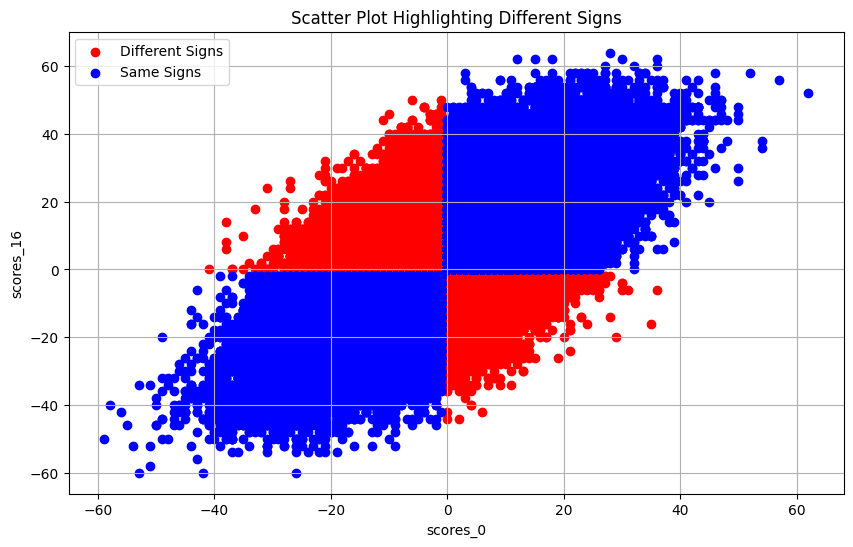

In [ ]:
# Create a condition array where True denotes different signs between x and y
transformed_scores_0 = transform_to_nonnegativity(scores_0_16)
different_signs = np.sign(transformed_scores_0) != np.sign(transformed_scores_16)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(scores_0_16[different_signs], scores_16_16[different_signs], color='red', label='Different Signs')
plt.scatter(scores_0_16[~different_signs], scores_16_16[~different_signs], color='blue', label='Same Signs')
plt.xlabel('scores_0')
plt.ylabel('scores_16')
plt.title('Scatter Plot Highlighting Different Signs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
np.sum(different_signs)

27002

In [ ]:


# Using numpy.unique to find unique elements and their counts
unique_elements, counts = np.unique(scores_0_16, return_counts=True)

# Printing the elements and their frequencies
# for element, count in zip(unique_elements, counts):
    # print(f'Element {element}: {count} times')

#### Feed more data

With small sample (size 10k), the trained acc of model is significantly lower (65%, also overfits much earlier after ~epoch 5). Reproducible using data in `16_10k_20240510`. \\
We hereby train another model with 1M data.

##### Testing with small sample (0.1x)

In [ ]:
def transform_to_positivity(arr):
    positivity_array = np.zeros_like(arr, dtype=np.int16)
    positivity_array[arr > 0] = 1
    positivity_array[arr < 0] = -1
    return positivity_array

X = extract_states("16_10k_20240510/obf")
scores_16_16 = extract_scores("16_10k_20240510/eval_16.txt")
transformed_scores_16 = transform_to_positivity(scores_16_16)
X_train, X_test, y_train, y_test = train_test_split(X, transformed_scores_16, test_size=0.2)

# transform y to catagorical
y_train += 1
y_test += 1
y_test


array([0, 0, 2, ..., 0, 2, 2], dtype=int16)

In [ ]:
# Define your model hyperparameters
input_shape = (64,)  # Input shape of your data (for flattened input)
num_classes = 3  # Number of classes in your dataset
learning_rate = 0.001
batch_size = 32
epochs = 100

def create_fc_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create an instance of your model
model = create_fc_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Report loss & Acc for epoch 0 as it's not reported by model.fit
initial_training_loss, initial_training_accuracy = model.evaluate(X_train, y_train)
initial_testing_loss, initial_testing_accuracy = model.evaluate(X_test, y_test)

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # Only consider improvements that decrease the loss by at least 0.001
    patience=20,      # Number of epochs with no significant improvement
    verbose=1,
    mode='min'
)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

63/63 [==============================] - 1s 8ms/step - loss: 1.1739 - accuracy: 0.3300
Epoch 1/100
250/250 [==============================] - 4s 7ms/step - loss: 0.8059 - accuracy: 0.6060 - val_loss: 0.7704 - val_accuracy: 0.6420
Epoch 2/100
250/250 [==============================] - 2s 7ms/step - loss: 0.7307 - accuracy: 0.6669 - val_loss: 0.7664 - val_accuracy: 0.6375
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.7012 - accuracy: 0.6835 - val_loss: 0.7695 - val_accuracy: 0.6430
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6896 - accuracy: 0.6879 - val_loss: 0.7735 - val_accuracy: 0.6435
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.7010 - val_loss: 0.7742 - val_accuracy: 0.6435
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6583 - accuracy: 0.7081 - val_loss: 0.7817 - val_accuracy: 0.6390
Epoch 7/100
250/250 [==============================] - 

##### Testing with large sample (10x)

In [35]:
def transform_to_positivity(arr):
    positivity_array = np.zeros_like(arr, dtype=np.int16)
    positivity_array[arr > 0] = 1
    positivity_array[arr < 0] = -1
    return positivity_array

X = extract_states("16_1M_20240509/obf")
scores_16_16 = extract_scores("16_1M_20240509/eval_16.txt")
transformed_scores_16 = transform_to_positivity(scores_16_16)
X_train, X_test, y_train, y_test = train_test_split(X, transformed_scores_16, test_size=0.2)

# transform y to catagorical
y_train += 1
y_test += 1
y_test


array([2, 2, 1, ..., 2, 2, 2], dtype=int16)

In [36]:
# Define your model hyperparameters
input_shape = (64,)  # Input shape of your data (for flattened input)
num_classes = 3  # Number of classes in your dataset
learning_rate = 0.001
batch_size = 32
epochs = 100

def create_fc_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create an instance of your model
model = create_fc_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Report loss & Acc for epoch 0 as it's not reported by model.fit
initial_training_loss, initial_training_accuracy = model.evaluate(X_train, y_train)
initial_testing_loss, initial_testing_accuracy = model.evaluate(X_test, y_test)

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # Only consider improvements that decrease the loss by at least 0.001
    patience=20,      # Number of epochs with no significant improvement
    verbose=1,
    mode='min'
)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

6250/6250 [==============================] - 12s 2ms/step - loss: 1.0738 - accuracy: 0.4064
Epoch 1/100
25000/25000 [==============================] - 86s 3ms/step - loss: 0.7307 - accuracy: 0.6674 - val_loss: 0.7123 - val_accuracy: 0.6819
Epoch 2/100
25000/25000 [==============================] - 72s 3ms/step - loss: 0.7031 - accuracy: 0.6884 - val_loss: 0.6783 - val_accuracy: 0.7043
Epoch 3/100
25000/25000 [==============================] - 76s 3ms/step - loss: 0.6798 - accuracy: 0.7047 - val_loss: 0.6627 - val_accuracy: 0.7143
Epoch 4/100
13515/25000 [===============>..............] - ETA: 28s - loss: 0.6683 - accuracy: 0.7118

#### Modified model

In [ ]:
def transform_to_nonnegativity(arr):
    positivity_array = np.zeros_like(arr, dtype=np.int16)
    positivity_array[arr >= 0] = 1
    positivity_array[arr < 0] = 0
    return positivity_array

X = extract_states("100k_20240502/test_obf_16_100k_20240502")
scores_16_16 = extract_scores("100k_20240502/eval_16_16_100k_20240502.txt")
scores_0_16 = extract_scores("100k_20240502/eval_0_16_100k_20240502.txt")
transformed_scores_16 = transform_to_nonnegativity(scores_16_16)
X_train, X_test, y_train, y_test = train_test_split(X, transformed_scores_16, test_size=0.2)

In [ ]:
# Define your model hyperparameters
input_shape = (64,)  # Input shape of your data (for flattened input)
num_classes = 2  # Number of classes in your dataset
learning_rate = 0.001
batch_size = 32
epochs = 100

def create_fc_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create an instance of your model
model = create_fc_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Report loss & Acc for epoch 0 as it's not reported by model.fit
initial_training_loss, initial_training_accuracy = model.evaluate(X_train, y_train)
initial_testing_loss, initial_testing_accuracy = model.evaluate(X_test, y_test)

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # Only consider improvements that decrease the loss by at least 0.001
    patience=20,      # Number of epochs with no significant improvement
    verbose=1,
    mode='min'
)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

### Evaluate model on other game stages

#### 11 squares

In [ ]:
X = extract_states("100k_20240508/test_obf_11_100k_20240508")
scores_0_11 = extract_scores("100k_20240508/eval_0_11_100k_20240508.txt")
scores_11_11 = extract_scores("100k_20240508/eval_11_11_100k_20240508.txt")

In [ ]:
transformed_scores_11 = transform_to_positivity(scores_11_11)
transformed_scores_11 += 1
model.evaluate(X, transformed_scores_11)

*italicized text*## CNN model